<a href="https://colab.research.google.com/github/gomlfx/ApiaryFund/blob/master/GluonTS_1_2_deep_factor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
#install GluonTS
!pip install --upgrade mxnet~=1.7 gluonts

     |████████████████████████████████| 47.3 MB 1.5 MB/s 
     |████████████████████████████████| 2.1 MB 49.8 MB/s 
     |████████████████████████████████| 10.9 MB 43.2 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [35]:
#metatrader 5 history file an timeframe is ok
df = pd.read_csv('/content/EURUSD_H4_200001030000_202202021200.csv')


In [36]:
#split mt5 into columns
df.columns=['header']
df = df.header.str.split('\t', expand=True)

In [37]:
#check the splits
df

,0,1,2,3,4,5,6,7,8
0,2010.09.10,12:00:00,1.27164,1.27370,1.26861,1.27047,7904,0,9
1,2010.09.10,16:00:00,1.27050,1.27435,1.26903,1.27135,6969,0,8
2,2010.09.10,20:00:00,1.27133,1.27291,1.26750,1.26784,3107,0,12
3,2010.09.13,00:00:00,1.27050,1.27945,1.27040,1.27828,5235,0,12
4,2010.09.13,04:00:00,1.27825,1.28074,1.27800,1.27946,4844,0,9
...,...,...,...,...,...,...,...,...,...
17717,2022.02.01,20:00:00,1.12448,1.12735,1.12427,1.12718,8213,0,0
17718,2022.02.02,00:00:00,1.12715,1.12770,1.12679,1.12764,3482,0,0
17719,2022.02.02,04:00:00,1.12765,1.12779,1.12705,1.12731,3804,0,0
17720,2022.02.02,08:00:00,1.12732,1.12942,1.12667,1.12932,11753,0,0


In [38]:
#merge date and time to convert object to datetime to use as GluonTS index
selected_columns = df[[0,1,5]]
new_df = selected_columns.copy()
print(new_df)

                0         1        5
0      2010.09.10  12:00:00  1.27047
1      2010.09.10  16:00:00  1.27135
2      2010.09.10  20:00:00  1.26784
3      2010.09.13  00:00:00  1.27828
4      2010.09.13  04:00:00  1.27946
...           ...       ...      ...
17717  2022.02.01  20:00:00  1.12718
17718  2022.02.02  00:00:00  1.12764
17719  2022.02.02  04:00:00  1.12731
17720  2022.02.02  08:00:00  1.12932
17721  2022.02.02  12:00:00  1.13148

[17722 rows x 3 columns]


In [39]:
new_df['date_time_index'] = df[0] +' '+ df[1]
new_df = new_df.drop(columns = [0,1])

In [40]:
new_df = new_df.rename(columns={5:'price'})

In [41]:
#convert mt5 object formats to datetime and float
df2 = new_df[['date_time_index','price']]
df2['date_time_index'] = pd.to_datetime(df2['date_time_index'])
df2['price'] = df2['price'].astype(float, errors = 'raise')
df2 = df2.set_index('date_time_index')
print(df2)

                       price
date_time_index             
2010-09-10 12:00:00  1.27047
2010-09-10 16:00:00  1.27135
2010-09-10 20:00:00  1.26784
2010-09-13 00:00:00  1.27828
2010-09-13 04:00:00  1.27946
...                      ...
2022-02-01 20:00:00  1.12718
2022-02-02 00:00:00  1.12764
2022-02-02 04:00:00  1.12731
2022-02-02 08:00:00  1.12932
2022-02-02 12:00:00  1.13148

[17722 rows x 1 columns]


In [42]:
#check it is done
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17722 entries, 2010-09-10 12:00:00 to 2022-02-02 12:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   17722 non-null  float64
dtypes: float64(1)
memory usage: 276.9 KB


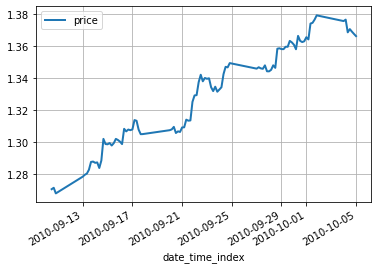

In [43]:
#print the data range from above
import matplotlib.pyplot as plt
df2[:100].plot(linewidth=2)
plt.grid(which='both')
plt.show()

In [30]:
#import Gluon
from gluonts.dataset.common import ListDataset

In [44]:
#choose data range to train
training_data = ListDataset(
    [{"start": df2.index[0], "target": df2.price["2000-01-01 01:00:00":"2022-02-02 12:00:00"]}], 
    freq = "4H"
    )

In [14]:
#import model 
from gluonts.model.deepar import DeepAREstimator

from gluonts.model.deep_factor._network import DeepFactorPredictionNetwork, DeepFactorTrainingNetwork
from gluonts.model.deep_factor.RNNModel import RNNModel

from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator

from gluonts.mx.trainer import Trainer

In [45]:
#train model
estimator = DeepFactorEstimator(freq="4H", prediction_length=24,  batch_size=100, trainer=Trainer(epochs=10, num_batches_per_epoch=100))
#estimator = DeepFactorEstimator(freq="1H", prediction_length=124, trainer=Trainer(epochs=3))

predictor = estimator.train(training_data=training_data)

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:328: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  retur

In [46]:
#choose data range to predict
test_data = ListDataset(
    [{"start": df2.index[0], "target": df2.price[:"2022-02-02 12:00:00"]}],
    freq = "4H"
)

/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


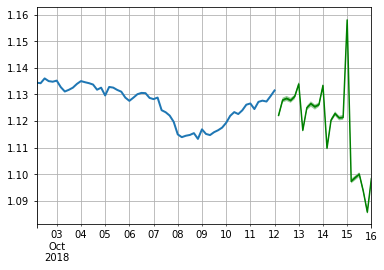

In [47]:
#plot prediction graph
from gluonts.dataset.util import to_pandas

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry)[-60:].plot(linewidth=2)
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0])
plt.grid(which='both')

In [18]:
from gluonts.evaluation import make_evaluation_predictions

In [48]:

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


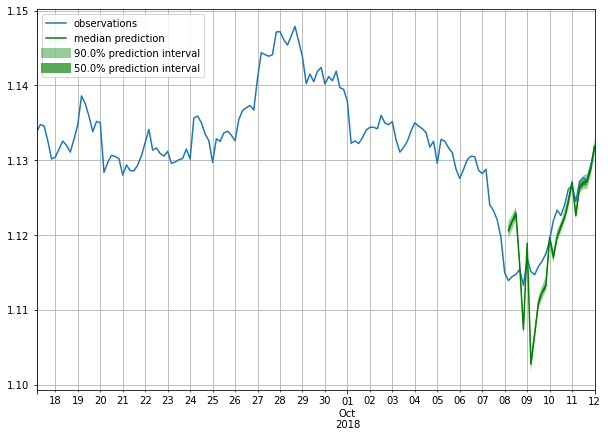

In [49]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,  # test dataset
    predictor=predictor,  # predictor
    num_samples=24,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

plot_prob_forecasts(tss[0], forecasts[0])